<a href="https://colab.research.google.com/github/loveyazuma/Chlorophyll-Estimation-using-Regression/blob/main/chlorophyll_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Chlorophyll Estimation Using Linear and KNN Regeression
 Estimation of the chlorophyll content from a hyperspectral image using linear regression and K-NN regression 


### Processes
- The data was read in and the histogram of chlorophyll was visualized
- A train/test split was performed for training and testing the models
- The data was normalised and a linear model was applied after normalisation
- The coefficients of the linear model were visualised and a scatter plot created
- The optimal number of neighbours was identified and applied to the KNN model and a scatter plot was visualised
- The regression models were applied to the hyperspectral image and values were predicted

In [4]:
# Run rmagic
%load_ext rpy2.ipython

In [6]:
%%R
# install packages if not already installed
list.of.packages <- c("raster", "rgdal", "FNN", "ggplot2")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)>0) {install.packages(new.packages)}

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘sp’, ‘terra’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/sp_1.4-6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1423843 bytes (1.4 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [8]:
%%R
# load packages 
library(raster)
library(rgdal)
library(FNN) #library for KNN
library(ggplot2) #library for plotting

#clear env
rm(list=ls())

R[write to console]: Loading required package: sp

R[write to console]: Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-28, (SVN revision 1158)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-6



In [9]:
# load file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%%R
###read data###
#Set the directory where you put the data
setwd("/content/drive/MyDrive/R_code")

#read the csv
data <- as.data.frame(t(read.csv("J_SPARC_one_day.csv")))

#obtain the wavelenghts
wavelengths <- data[1,]

#remove the first row
data <- data[2:nrow(data),]

#put the right name for the rows
rownames(data) <- c(paste("Sample", seq_len(nrow(data)), sep = "_"))

#and for the columns
colnames(data) <- colnames(data) <- c("Chlorophyll", "LAI", "FCover", wavelengths[,4:65])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.67   27.33   44.00   37.10   48.50   52.16 


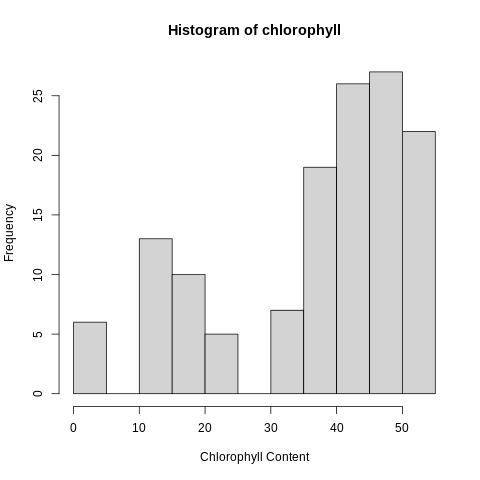

In [32]:
%%R
###Visualization histogram of chlorophyll###
#Use hist() function
chlorophyll <- data$Chlorophyll
hist(chlorophyll,
     xlab = 'Chlorophyll Content')
#Some additional statistics on chlorophyll for a better insight
summary(chlorophyll)

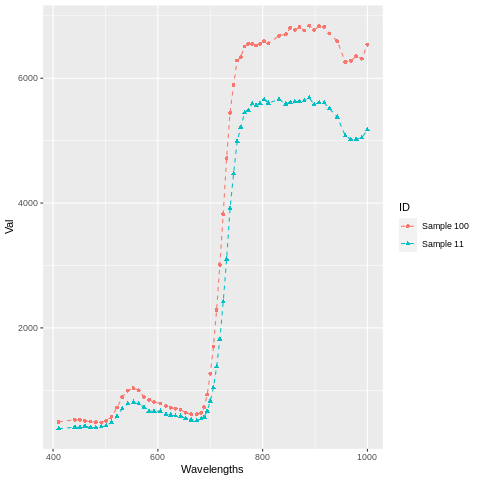

In [17]:
%%R
###Show spectral values (unormalized)###
sample_id = 11
spectral_val <- data.frame(t(wavelengths[1,4:ncol(wavelengths)]), t(data[sample_id,4:ncol(data)]), paste("Sample",sample_id,sep = " "))
colnames(spectral_val) <- c("Wavelengths", "Val", "ID")
sample_id = 100
spectral_val2 <- data.frame(t(wavelengths[1,4:ncol(wavelengths)]), t(data[sample_id,4:ncol(data)]), paste("Sample",sample_id,sep = " "))
colnames(spectral_val2) <- c("Wavelengths", "Val", "ID")
spectral_val <- rbind(spectral_val, spectral_val2)
ggplot(data=spectral_val, aes(x=Wavelengths, y=Val, color=ID, shape=ID)) + geom_point() + geom_line(linetype = "dashed")

In [19]:
%%R
###perform train/test split###
set.seed(90)
train_samples <- sample(seq_len(nrow(data)), size = 90)
train_ground_truth <- data[train_samples,-(2:3)]
test_ground_truth <- data[-train_samples,-(2:3)]

###Apply linear model###
linear_reg <- lm(Chlorophyll~., data=train_ground_truth)
pred_test <- predict(linear_reg, test_ground_truth)

RMSE_linear <- sqrt(mean((test_ground_truth$Chlorophyll-pred_test)^2))
MAE_linear <- mean(abs(test_ground_truth$Chlorophyll-pred_test))
R2_linear <- 1 - sum((test_ground_truth$Chlorophyll-pred_test)^2)/sum((test_ground_truth$Chlorophyll-mean(test_ground_truth$Chlorophyll))^2)

###normalize data###
data_norm <- data
data_norm[,4:65] <- data_norm[,4:65] / data_norm[,57]

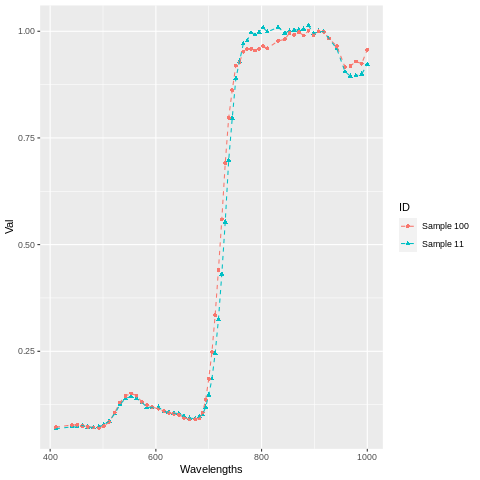

In [33]:
%%R
###Show spectral values after normalization###
sample_id = 11
spectral_val <- data.frame(t(wavelengths[1,4:ncol(wavelengths)]), t(data_norm[sample_id,4:ncol(data)]), paste("Sample",sample_id,sep = " "))
colnames(spectral_val) <- c("Wavelengths", "Val", "ID")
sample_id = 100
spectral_val2 <- data.frame(t(wavelengths[1,4:ncol(wavelengths)]), t(data_norm[sample_id,4:ncol(data)]), paste("Sample",sample_id,sep = " "))
colnames(spectral_val2) <- c("Wavelengths", "Val", "ID")
spectral_val <- rbind(spectral_val, spectral_val2)
ggplot(data=spectral_val, aes(x=Wavelengths, y=Val, color=ID, shape=ID)) + geom_point() + geom_line(linetype = "dashed")


## Linear Regression


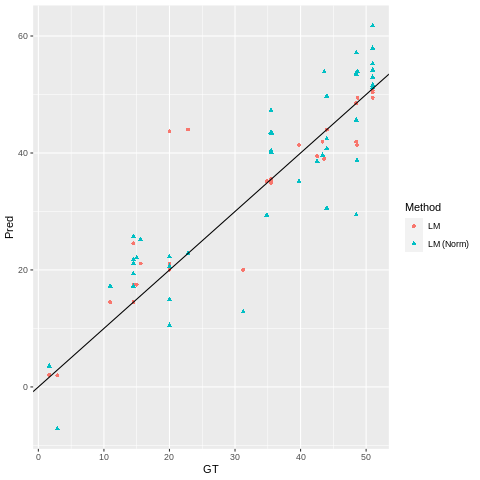

In [37]:
%%R
###apply linear regression after normalization###
train_norm <- data_norm[train_samples,-(2:3)]
test_norm <- data_norm[-train_samples,-(2:3)]

linear_reg_norm <- lm(Chlorophyll~., data=train_norm)
pred_test_norm <- predict(linear_reg_norm, test_norm)
RMSE_norm <- sqrt(mean((test_norm$Chlorophyll - pred_test_norm)^2))
MAE_norm <- mean(abs(test_norm$Chlorophyll - pred_test_norm))
R2_norm <- 1 - sum((test_norm$Chlorophyll - pred_test_norm)^2) / sum((test_norm$Chlorophyll - mean(test_norm$Chlorophyll))^2)


###Make the scatter plot###
lm_scatter <- data.frame(rownames(test_ground_truth), test_ground_truth[,1], unname(pred_test), "LM")
colnames(lm_scatter) <- c("Sample_id", "GT", "Pred", "Method")
lm_scatter2 <- data.frame(rownames(test_norm), test_norm[,1], unname(pred_test_norm), "LM (Norm)")
colnames(lm_scatter2) <- c("Sample_id", "GT", "Pred", "Method")
lm_scatter <- rbind(lm_scatter, lm_scatter2)
ggplot(data=lm_scatter, aes(x=GT, y=Pred, color=Method, shape=Method)) + geom_point() + geom_abline(slope=1, intercept = 0)

## K-Nearest Neighbour Regression

New best model:  1  ( 1.991702 )
New best model:  2  ( 1.926484 )


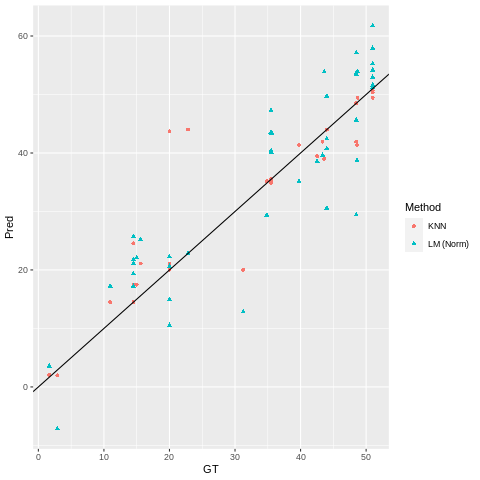

In [36]:
%%R
###KNN reg###
knn <- knn.reg(train_norm[,-1], test_norm[,-1], train_norm$Chlorophyll, k=6)
pred_test <- knn$pred
RMSE_knn_normalized <- sqrt(mean((test_norm$Chlorophyll - pred_test)^2))
MAE_knn_normalized <- mean(abs(test_norm$Chlorophyll - pred_test))
R2_knn_normalized <- 1 - sum((test_norm$Chlorophyll - pred_test)^2) / sum((test_norm$Chlorophyll - mean(test_norm$Chlorophyll))^2)
  
###find the best number of neighbors###
best_RMSE <- 10000000
best_k <- -1

for (k in seq(1:20)){
  knn <- knn.reg(train_norm[1:70,-1], train_norm[71:90,-1], train_norm$Chlorophyll[1:70], k=k)
  pred_test <- knn$pred 
  RMSE <- sqrt(mean((train_norm$Chlorophyll[71:90] - pred_test)^2))
  
  if (RMSE < best_RMSE) {
    best_RMSE <- RMSE
    best_k = k
    cat("New best model: ", k , " (", best_RMSE, ")\n")
  }
}

###Apply KNN with the best number of neighbors###
knn <- knn.reg(train_norm[,-1], test_norm[,-1], train_norm$Chlorophyll, k=best_k)
pred_test = knn$pred

###Show the scatter plot###
knn_scatter <- data.frame(rownames(test_ground_truth), test_ground_truth[,1], unname(pred_test), "KNN")
colnames(knn_scatter) <- c("Sample_id", "GT", "Pred", "Method")
lm_scatter2 <- data.frame(rownames(test_norm), test_norm[,1], unname(pred_test_norm), "LM (Norm)")
colnames(lm_scatter2) <- c("Sample_id", "GT", "Pred", "Method")
lm_scatter2 <- rbind(knn_scatter, lm_scatter2)
ggplot(data=lm_scatter2, aes(x=GT, y=Pred, color=Method, shape=Method)) + geom_point() + geom_abline(slope=1, intercept = 0)


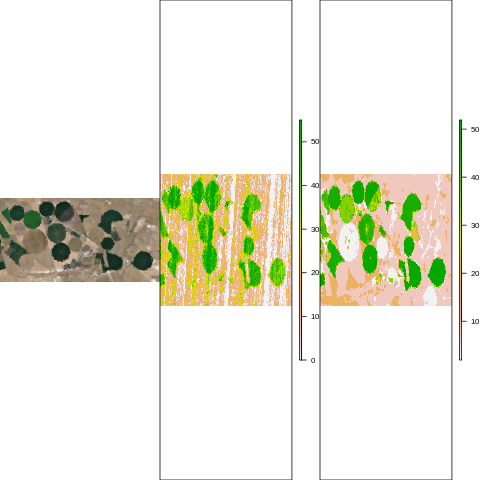

In [38]:
%%R
###Apply regression models on image###
raster_img <- stack("CHRIS.tif")

maxs <- cellStats(raster_img, stat='max')
par(mfrow=c(1,3))
plotRGB(raster_img/maxs*255, r=23,g=13,b=3, main='Input image')

###Apply lm###
img <- as.data.frame(raster_img, xy=TRUE)
colnames(img) <- c("x", "y", paste(wavelengths[1,4:ncol(wavelengths)]))
#Normalize
img[,3:64] <- img[,3:64] / img[,56]
#Predict
pred_img <- as.data.frame(predict(linear_reg_norm, img))
#Convert to matrix
mat_img <- matrix(unlist(pred_img), nrow=dim(raster_img)[1], ncol=dim(raster_img)[2],byrow = TRUE)
#Clip values
mat_img[mat_img<0] <- 0
mat_img[mat_img>55] <- 55
img_lm <- raster(mat_img)
plot(img_lm, axes=FALSE, main='Linear regression', asp=1)

#Apply knn
mat_img <- raster::as.matrix(raster_img)
#Normalize
mat_img[,] <- mat_img[,] / mat_img[,54]
#Give meaningful names to the column
colnames(mat_img) <- wavelengths[1, 4:ncol(wavelengths)]

#Apply KNN
knn <- knn.reg(train_norm[-(1)], mat_img, train_norm$Chlorophyll, k=best_k)
img_knn <- raster(matrix(knn$pred, nrow=dim(raster_img)[1], ncol=dim(raster_img)[2],byrow = TRUE))
plot(img_knn, axes=FALSE, main='KNN regression')